# Winning Model Documentation
## describing my solution for the Kaggle competition

## “Rossmann Store Sales”

### Gert Jacobusse gert.jacobusse@rogatio.nl
### Goes, december 2015


### Summary
In this competition I had to forecast 6 weeks of store sales for over 1000 Rossmann
stores, based on almost three years of sales history. The model I used was extreme
gradient boosting (XGBoost [1]) a general purpose tool that is based on decision
trees. My feature generation was guided by three main principles: for each train and
test record, the model should have features on 1) recent data 2) temporal information
and 3) current trends. For feature selection and model ensembling, I heavily exploited
a holdout set consisting of the last six weeks of the sales history.

저는 이 competition에서 3년의 판매이력을 이용해, 1000개의 Rossmann store들의 6주간의 판매를 예측하였습니다. 제가 사용한 model은 extreme gradient boosting (XGBoost [1]) 으로 decision tree에 바탕을 두는 일반적인 tool입니다. 저의 Feature generation은 3개의 주요 원칙에 따릅니다 : 각 train과 test record에서 model은 1) 최근 data 2) 일시적인 정보 3) 현재의 트랜드 에 대한 feature를 가져야 합니다. feature selection과 model ensembling을 위해, 마지막 6주간의 판매 이력을 포함하고 있는 holdout set을 중점적으로 이용했습니다.

### Features Selection / Extraction
For feature extraction, I distinguish three types of features, on 1) recent data 2)
temporal information and 3) current trends. I extracted a lot more features then I
ended up using.

Feature extraction을 위해, 저는 다음과 같이 3가지 feature type으로 분리했습니다 : 1) 최근 data 2) 시간 정보 3) 현재 trend. 저의 경우 먼저 굉장히 많은 feature들을 extract한 후에 그것들을 사용하였습니다.

#### Recent data
To create features on recent data, I selected store specific sets of sales data for each
month in the the train set (i.e. the three years of sales history). Then for each record, I
took the date of that record, and used data from the previous month and further back
as the recent history of that record. I extracted features on last quarter, last half year,
last year and last 2 years. I also experimented with last month only, but thought it
would not be useful to predict sales as far as six weeks ahead.
The recent data on store as a whole were still wildly varying, and I identified three
features that contributed most to this variance: the day of the week, promotions and
holidays. Therefore, I further split out my store specific sets by those three variables
and calculated recent averages on diverse combinations of them.
To summarize the recent data, I used measures of centrality: median, mean and
harmonic mean - and measures of spread: standard deviation, skewness, kurtosis and
10%/ 90% percentiles. I also tried to log transform the sales before summarizing, but
only one of those transformed variables survived the feature selection.
In one variation to the main model, I calculated the recent data features on number of
customers, instead of sales amount.

최근 data에 대한 feature들을 만들기 위해, train set에서 각 월별로 가게에 한정되어있는 판매 data를 골랐습니다 (예 : 3년간의 판매 이력). 그리고 난 뒤 각 기록을 위해, 그 기록의 날짜를 가져와서 지난 달, 그리고 훨씬 이전의 data를 그 기록의 최근 기록으로 사용하였습니다. 지난 분기, 지난 반년, 지난 1년, 지난 2년간의 feature를 extract하였습니다. 지난 달의 기록만도 사용해 봤었는데, 6주간의 판매를 예상하는 데에는 유용하지 않은 것 같습니다. 

#### Temporal information
For temporal information I created ‘day counters’ to express how each record relates
to certain events or cycles. The day counter indicates either the number of days
before, after or within the event. As events I had the promotion cycle (every 14 days),
the secondary promotion cycle (every three months), the summer holidays (important
because they partly took place during the 6 weeks test set), store refurbishments, start
of competition and start of secondary promotion cycle. And also the day of week, day
of month, and day/ week/ month of year. Apart from the day counters, I also added
features on the number of holidays during the current week, last week and next week.


#### Current trends
To estimate store sales trends, I used data sets about the last quarter and the last year,
similar to the data sets for recent data features. Within each dataset, I fit a store
specific linear model on 1) the day number - to extrapolate the trend into the six week
period 2) day of week and 3) promotions. As a linear model I used Ridge regression
from scikits-learn [2] with default regularization parameter, I did not try any
alternatives. For each store I also calculated the year over year trend for the previous
month, but that feature seems to be of minor importance.


#### Other information
Other important information was about the store: the dataset variables store id,
assortment and storetype, together with some aggregates by store: the average sales
per customer, the ratio of sales during promotions/ holidays/ Saturdays, the
proportion school holidays and the proportion of days that the store is open. Finally,
it helped to include data about the state specific weather: maximum temperature an
mm precipitation, downloaded from the forum [3].


#### Selection of features and Model ensembling
I created a lot more features - especially temporal information - than the model could
handle. With all features together, the model easily overfit the train set, resulting in
suboptimal performance on the test set. Therefore, I needed a way to reduce the
feature set and select features that are most helpful to forecast into the test set. As a
proxy for the test set, I used my validation set consisting of the last 6 weeks of the
train set. I started off by handpicking some combinations that seemed to make sense
to me. This way I soon noted that the spread features made overfitting easy. The
handpicking cost me a lot of time and I realized that it was biased by my ideas.
Therefore I decided to create some models on random selections of the features.
Some of the best performing random models gave nice improvements when I
ensembled them with my handpicked models. After noting that, I ran over 500
random models and systematically calculated the validation error on each pairensemble
of models. From the best model pairs I built a larger ensemble, consisting
of more than 10 different models (actually the same models with different features).
Then I got the idea to take the features from all of the selected models together and
combine them into one model: this turned out to work very well - in the end I only
kept this combined model together with two of the handpicked models. In this
process as a whole, model ensembling and feature selection went hand in hand.


### Modeling Techniques and Training
For modeling I completely relied on XGBoost and my focus was entirely on feature
extraction and selection. I started off from the parameters in the (in)famous public
script [4] that performed a lot better on the public leaderboard than I could reproduce
within my holdout set. During some experiments, I only changed the number of
rounds (from 3000 to 5000) and de column sample by tree (from 0.7 to 0.3 because I
had a lot of features).


To further enrich and stabilize my ensemble of models, I added separate models that
were only trained on the months May to September, over all three years. I chose these
months because they cover the test set months and have some 2015 history before the
test set. Another ensembling trick was to add ‘month ahead models’ that skipped the
most recent month for the calculation of recent/trend features. These ‘month ahead
models’ were almost as good as the models that did use all the most recent data. For
prediction of the sales in the second month of the test set (where sales in the most
recent month were not available at all) I used an ensemble of only ‘month ahead
models’.


Like most other teams, I log transformed the dependent variable (sales) and did not
include zero sales for training the model. For final ensembling I applied the harmonic
mean. I also multiplied all my predictions with a constant factor to improve them. A
factor of 0.995 was optimal for both my validation set and the public test set. But I
should have applied the mathematical estimate of 0.985 on the forum [5] to achieve a
private leaderboard score well below 0.10.


### Code Description
The code is written in Python and consists of a ‘main’ script where the whole
procedure takes place by calling functions from three modules: ‘loaddata’ to load the
original data into a sqlite database, ‘extractfeatures’ to extract the features and
‘runmodels’ to run and ensemble the models.


The main code starts with a dictionary ‘features’ that contains all the feature names as
keys, and contains a list with four binary entries that indicate in which models each
feature is used. After that, two lists are created, defining which models to ensemble
for the august and september predictions respectively. After that, all functions from
the modules are called in the right order. Information about progress will be printed to
stdout by the functions.


#### Dependencies
The following modules are required to run the code.
main: os, sqlite3, scipy
loaddata: sys, csv
extractfeatures: sys, csv, math, numpy, scipy, datetime, pickle, collections, sklearn
runmodels: sys, csv, math, numpy, xgboost


#### How To Generate the Solution (aka README file)
The working directory should contain a folder ‘data’, in turn containing ‘train.csv’,
‘test.csv’, ‘store.csv’, ‘vakanties.csv’ (for holiday starts, from schulferien.org and
mentioned in [6]) and the folder ‘weer’ that contains the weather files. Make sure that
dependencies are installed, start running main and have some patience…


### Additional Comments and Observations
Two findings surprised me: first, that the ‘month ahead models’ performed almost as
good as the models that did include information from the most recent month. This
implies that recent changes are not very important to predict the sales six weeks
ahead. My interpretation of this finding is that the Rossmann sales figures represent a
fairly stationary process. Second, I was surprised by the fact that I could use my
holdout set to select model pairs from over 500*250 (n*[n-1]/2) pairs without
overfitting.


Not all my features made it into the final model selection. Some efforts to capture the
annual variation of sales over all stores together, by including monthly or daily sales
averages, did not improve the model - I think they were overshadowed by the
promotion effects. Also, aggregates by day (what proportion of stores had holidays,
what proportion was open - today, yesterday and tomorrow) and aggregates about the
spread of sales within each store were not useful. And some additional external data
that I tried were not helpful either: state statistics on population and income, monthly
sales figures from different sources and information about search term popularity
from Google trends.


### Simple Features and Methods
I did compare some other models to XGBoost, but none of them were useful, neither
on their own nor in the ensemble. Most of the individual XGBoost models already
achieve around 0.105 on the private leaderboard - those individual models are simpler
in the sense that no meta model ensembling is involved.

### References
1. XGBoost https://github.com/dmlc/xgboost
2. Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp.
2825-2830, 2011.
3. The weather data on the forum: https://www.kaggle.com/c/rossmann-store-sales/
forums/t/17058/weather-at-berlin-us-airport
4. The (in)famous public script: https://www.kaggle.com/abhilashawasthi/
rossmann-store-sales/xgb-rossmann/run/86608
5. The forum post about correcting predictions: https://www.kaggle.com/c/
rossmann-store-sales/forums/t/17601/correcting-log-sales-prediction-for-rmspe
6. The forum thread on external data: https://www.kaggle.com/c/rossmann-storesales/
forums/t/17229/external-data-and-other-information?page=2

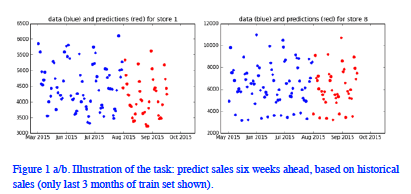

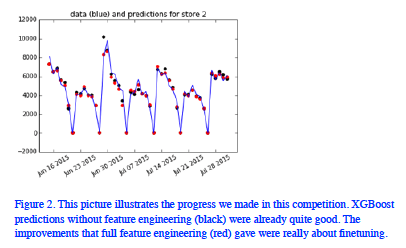

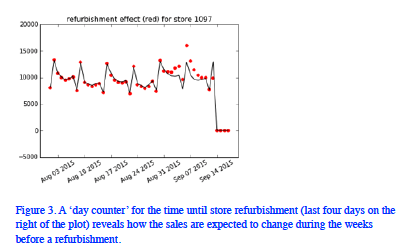